# Basic Metrics for domains lateralized graphs

New threshold method

In [11]:
import networkx as nx
import pandas as pd
import numpy as np
import pickle
import brainmaptools as brainmap
import community
import matplotlib.pyplot as plt
import brainx.modularity as md
%matplotlib inline
import graph_functions
import scipy
import math

In [63]:
datadir='/Users/rsblumenfeld/work/PFC_Brainmap/data/'
relabel_file='/Users/rsblumenfeld/work/PFC_Brainmap/data/Label_dict.pck'

domains= ['Memory', 'Working Memory', 'Emotion', 'Attention', 'Language', 'Vision', 'Audition']
domains_base= ['Base', 'Memory', 'Working Memory', 'Emotion', 'Attention', 'Language', 'Vision', 'Audition']
domains_file='/Users/rsblumenfeld/work/meta-connect/data/Behavioral_Domains/studies_filtered_by_domain.pck'

wrk_L="/Users/rsblumenfeld/work/PFC_Brainmap/data/workspace_raw_L.txt"
wrk_R="/Users/rsblumenfeld/work/PFC_Brainmap/data/workspace_raw_R.txt"

rgn_L="/Users/rsblumenfeld/work/PFC_Brainmap/data/region_L.txt"
rgn_R="/Users/rsblumenfeld/work/PFC_Brainmap/data/region_R.txt"

tst="/Users/rsblumenfeld/work/PFC_Brainmap/data/tst.txt"

with open(wrk_L) as f:
    workspaces_L = f.readlines()
with open(wrk_R) as f:
    workspaces_R = f.readlines()
    
with open(rgn_L) as f:
    regionlist_L = f.readlines()
with open(rgn_L) as f:
    regionlist_R = f.readlines()


keycodes_L=brainmap.build_key_codes_from_workspaces(workspaces_L, datadir) 
keycodes_R=brainmap.build_key_codes_from_workspaces(workspaces_R, datadir) 
    

regions_L=[x[:-1] for x in regionlist_L]
regions_R=[x[:-1] for x in regionlist_R]

relabel_L={idx:x[:-1] for idx, x in enumerate(regionlist_L)}
relabel_R={idx:x[:-1] for idx, x in enumerate(regionlist_R)}


domain_dict=pickle.load(open(domains_file,'rb'))
domain_keycodes_L={domain: brainmap.domain_filter_keycodes(keycodes_L, domain_dict, domain) for domain in domains}
domain_keycodes_R={domain: brainmap.domain_filter_keycodes(keycodes_R, domain_dict, domain) for domain in domains}

ncontrasts_L=brainmap.number_of_contrasts(keycodes_L)
ncontrasts_R=brainmap.number_of_contrasts(keycodes_R)

domain_ncontrasts_L={domain : brainmap.number_of_contrasts(domain_keycodes_L[domain]) for domain in domains}
domain_ncontrasts_R={domain : brainmap.number_of_contrasts(domain_keycodes_R[domain]) for domain in domains}

### Unthresholded data

In [40]:
n_coactives_L=brainmap.build_n_coactives_array(keycodes_L)
n_coactives_R=brainmap.build_n_coactives_array(keycodes_R)

jaccard_array_L=brainmap.build_jaccard(n_coactives_L)
jaccard_array_R=brainmap.build_jaccard(n_coactives_R)

n_coactives_domain_L={ d_keys: brainmap.build_n_coactives_array(domain_keycodes_L[d_keys]) for d_keys in domains}
n_coactives_domain_R={ d_keys: brainmap.build_n_coactives_array(domain_keycodes_R[d_keys]) for d_keys in domains}

jaccard_domain_L={ d_keys: brainmap.build_jaccard(n_coactives_domain_L[d_keys]) for d_keys in domains}
jaccard_domain_R={ d_keys: brainmap.build_jaccard(n_coactives_domain_R[d_keys]) for d_keys in domains}

# Make Thresholded Lateralized Overall Graphs

In [43]:
p=0.05
base_thresh_ncoactives_L=brainmap.significant_connection_threshold(n_coactives_L, ncontrasts_L, p)
base_thresh_ncoactives_R=brainmap.significant_connection_threshold(n_coactives_R, ncontrasts_R, p)

In [44]:
base_mask_L=base_thresh_ncoactives_L>0
base_thresh_jaccard_L=base_mask_L*jaccard_array_L

base_mask_R=base_thresh_ncoactives_R>0
base_thresh_jaccard_R=base_mask_R*jaccard_array_R

# Make Domain Filtered Lateralized Graphs

In [45]:
domain_thresh_ncoactives_L={d_keys : brainmap.significant_connection_threshold(n_coactives_domain_L[d_keys], domain_ncontrasts_L[d_keys], p) for d_keys in domains}
domain_thresh_ncoactives_R={d_keys : brainmap.significant_connection_threshold(n_coactives_domain_R[d_keys], domain_ncontrasts_R[d_keys], p) for d_keys in domains}

domain_thresh_masks_L={}
domain_thresh_jaccard_L={}

domain_thresh_masks_R={}
domain_thresh_jaccard_R={}

for d_keys in domains:
    domain_thresh_masks_L[d_keys]= domain_thresh_ncoactives_L[d_keys]>0
    domain_thresh_masks_R[d_keys]= domain_thresh_ncoactives_R[d_keys]>0
    domain_thresh_jaccard_L[d_keys]=domain_thresh_masks_L[d_keys]*jaccard_domain_L[d_keys]
    domain_thresh_jaccard_R[d_keys]=domain_thresh_masks_R[d_keys]*jaccard_domain_R[d_keys]
    

/Users/rsblumenfeld/gitrepos/brainmaptools/brainmaptools/brainmaptools.py:127: RuntimeWarning: invalid value encountered in double_scalars
  p_one=(thresh_array[x][y])/(thresh_array[y][y])


In [58]:
G_domain_L={}
for d_keys in domains:
    G_domain_L[d_keys]=nx.from_numpy_matrix(domain_thresh_jaccard_L[d_keys])
    G_domain_L[d_keys]=nx.relabel_nodes(G_domain_L[d_keys],relabel_L)
    G_domain_L[d_keys].remove_edges_from(G_domain_L[d_keys].selfloop_edges())
    G_domain_L[d_keys]=brainmap.remove_edgeless_nodes(G_domain_L[d_keys])
    
    
G_domain_R={}
for d_keys in domains:
    G_domain_R[d_keys]=nx.from_numpy_matrix(domain_thresh_jaccard_R[d_keys])
    G_domain_R[d_keys]=nx.relabel_nodes(G_domain_R[d_keys],relabel_R)
    G_domain_R[d_keys].remove_edges_from(G_domain_R[d_keys].selfloop_edges())
    G_domain_R[d_keys]=brainmap.remove_edgeless_nodes(G_domain_R[d_keys])

In [62]:
G_L=nx.from_numpy_matrix(base_thresh_jaccard_L)
G_domain_L['Base']=G_L
G_domain_L['Base'].remove_edges_from(G_domain_L['Base'].selfloop_edges())
G_domain_L['Base']=nx.relabel_nodes(G_domain_L['Base'],relabel_L)
G_domain_L['Base']=brainmap.remove_edgeless_nodes(G_domain_L['Base'])

G_R=nx.from_numpy_matrix(base_thresh_jaccard_R)
G_domain_R['Base']=G_R
G_domain_R['Base'].remove_edges_from(G_domain_R['Base'].selfloop_edges())
G_domain_R['Base']=nx.relabel_nodes(G_domain_R['Base'],relabel_R)
G_domain_R['Base']=brainmap.remove_edgeless_nodes(G_domain_R['Base'])


In [74]:
domain_metrics_L={d_keys: brainmap.run_weighted_metrics(G_domain_L[d_keys], top_n=5) for d_keys in domains_base}
domain_metrics_R={d_keys: brainmap.run_weighted_metrics(G_domain_R[d_keys], top_n=5) for d_keys in domains_base}
metrics_L=brainmap.run_weighted_metrics(G_L, top_n=10)
metrics_R=brainmap.run_weighted_metrics(G_R, top_n=10)

In [75]:
for x in G_domain_R.keys():
    print x, G_domain_R[x].number_of_nodes()

Emotion 49
Language 42
Working Memory 47
Attention 60
Audition 8
Base 104
Memory 67
Vision 41


In [ ]:
domain_metrics_L[d_keys].keys()

saving data

In [ ]:
#pickle.dump(G_domain_L, open('G_domain_L.pck', 'wb'))
#pickle.dump(G_domain_R, open('G_domain_R.pck', 'wb'))
#pickle.dump(domain_metrics_L, open('domain_metrics_L.pck', 'wb'))
#pickle.dump(domain_metrics_R, open('domain_metrics_R.pck', 'wb'))


# Plot Degree distributions

/Users/rsblumenfeld/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


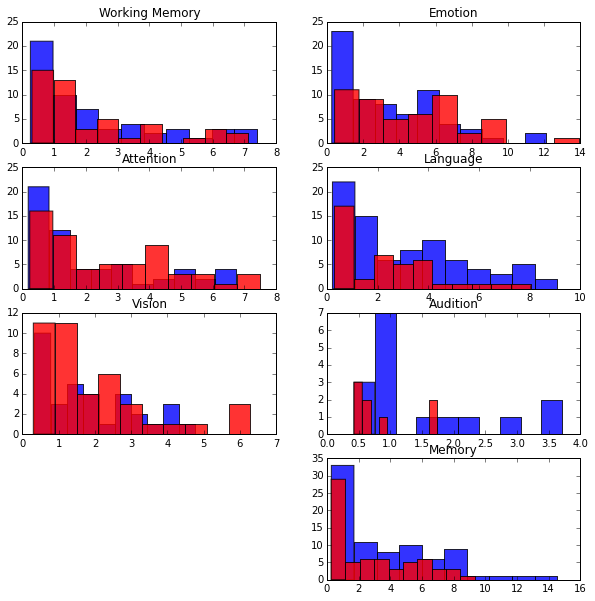

In [76]:
metric='degrees'
plt.figure(figsize=[10,10])
for y,d_keys in enumerate(domains):
    ax1=plt.subplot(4,2,y)
    plt.hist(domain_metrics_L[d_keys][metric].values(), color='b', alpha=0.8)
    plt.hist(domain_metrics_R[d_keys][metric].values(), color='r', alpha=0.8)
    plt.title(d_keys)

# Other metric histograms

In [ ]:
metric='degree_cent'
plt.figure(figsize=[10,10])
for y,d_keys in enumerate(domains):
    ax1=plt.subplot(4,2,y)
    plt.hist(domain_metrics_L[d_keys][metric].values(), color='b', alpha=0.8)
    plt.hist(domain_metrics_R[d_keys][metric].values(), color='r', alpha=0.8)
    plt.title(d_keys)

In [ ]:
metric='between_cent'
plt.figure(figsize=[10,10])
for y,d_keys in enumerate(domains):
    ax1=plt.subplot(4,2,y)
    plt.hist(domain_metrics_L[d_keys][metric].values(), color='b', alpha=0.8)
    plt.hist(domain_metrics_R[d_keys][metric].values(), color='r', alpha=0.8)
    plt.title(d_keys)

In [ ]:
metric='ccoeff'
plt.figure(figsize=[10,10])
for y,d_keys in enumerate(domains):
    ax1=plt.subplot(4,2,y)
    plt.hist(domain_metrics_L[d_keys][metric].values(), color='b', alpha=0.8)
    plt.hist(domain_metrics_R[d_keys][metric].values(), color='r', alpha=0.8)
    plt.title(d_keys)

# List Top 10s

create top_metric_dict which to store all the data for top 10s

In [ ]:
top_metric_dict_L={}
top_metric_dict_R={}
for metric in ['topdegrees','topdegree_cent','topbetween_cent', 'topccoeff']:
    top_metrics_L={}
    top_metrics_R={}
    for d_key in domains:
        top_metrics_L[d_key]=domain_metrics_L[d_key][metric]
        top_metrics_R[d_key]=domain_metrics_R[d_key][metric]
    top_metric_dict_L[metric]=top_metrics_L
    top_metric_dict_R[metric]=top_metrics_R

In [ ]:
top_metric_dict_R['topdegrees']['Memory']

In [ ]:
top_metric_dict_L['topdegrees']['Memory']

### Lists of nodes for Left and Right hemispheres

In [ ]:
G_coactives=nx.from_numpy_matrix(n_coactives)
G_coactives=nx.relabel_nodes(G_coactives, relabel_dict)
G_coactives.remove_nodes_from([223,224])
right=[x for x in G_coactives.nodes() if "_R_" in x]
left=[x for x in G_coactives.nodes() if "_L_" in x]

In [ ]:
#part_domains_avg_degree=np.zeros([len(part_bx['Base']), len(domains)])

#part_domain_degrees={}
#for x,module in enumerate(part_bx['Base']): #module
#    domain_degrees=np.zeros([len(domains), len(module)])
#    for z, domain in enumerate(domains):
#        for y,testnode in enumerate(module): #nodes in a module
#            if testnode in G[domain]:
#                domain_degrees[z,y]=G[domain].degree()[testnode] #grab all the node degrees for the nodes in module per domain
#        part_domains_avg_degree[x,z]=domain_degrees[z].mean()

In [ ]:
base_dict={0: set(part_bx['Base'][0]), 1: set(part_bx['Base'][1]),
           2: set(part_bx['Base'][2]), 3: set(part_bx['Base'][3])}
        

In [ ]:
G_cost['Base'][target]

In [ ]:
graph=G_cost['Base']
partition= base_dict
wd_dict = {}

paths = nx.shortest_path_length(G=graph)
for m in partition.keys():
        mod_list = partition[m]
        mod_wd_dict = {}
        for source in mod_list:
            count = 0
            for target in mod_list:
                if paths[source][target] == 1:
                    count += 1

In [ ]:
target

In [ ]:
wd_=graph_functions.within_module_degree(G['Base'], base_dict)

In [ ]:
G['Base'].nodes()

In [ ]:
part_domains_avg_degree=np.zeros([len(domains),len(part_bx['Base'])])

In [ ]:
part_bx['Base'][0]

In [ ]:
domains

In [ ]:
plt.plot(part_domains_avg_degree.transpose())

In [ ]:
domain_degrees=np.zeros([G['Base'].number_of_nodes(), len(domains)])


In [ ]:
testnode=G['Base'].nodes()[0]
if testnode in G['Memory'].nodes():
    foo=G['Memory'].degree()[testnode]

In [ ]:
#part_domains_avg_degree=np.zeros([len(domains),len(part_bx['Base'])])
part_domain_degrees={}
for x,module in enumerate(part_bx['Base']): #module
    domain_degrees=np.zeros([len(domains), len(module)])
    for y,testnode in enumerate(module): #nodes in a module
        for z, domain in enumerate(domains): #go domain by domain
            if testnode in G[domain]:
                domain_degrees[z,y]=G[domain].degree()[testnode] #grab all the node degrees for the nodes in module per domain
        

In [ ]:
domain_degrees[1]

In [ ]:
part_domains_avg_degree=np.zeros([len(domains),1])
for x,module in enumerate(part_bx['Base']):
    domain_degrees=np.zeros([len(domains), len(module)])
    for y,testnode in enumerate(module):
        for z, domain in enumerate(domains):
            if testnode in G[domain]:
                domain_degrees[z,y]=G[domain].degree()[testnode]
    for a, domain2 in enumerate(domain):
        part_domains_avg_degree[a]=domain_degrees[a].mean()
                

In [ ]:
part_domains_avg_degree

In [ ]:
part_domains_avg_degree[z,y]=
                G[domain].degree()[testnode]
            
        
    


for y,testnode in enumerate(part_bx['Base'].nodes()):
    domain_degrees=np.zeros([len(domains), len(module)])
    for z, domain in enumerate(domains):
        if testnode in G[domain]:
            domain_degrees[z,y]=G[domain].degree()[testnode]
        part_domains_avg_degree[z]=domain_degrees[z].mean()

In [ ]:
part_domains_avg_degree=np.zeros(len(domains))
for y,testnode in enumerate(G['Base'].nodes()):
    domain_degrees=np.zeros([len(domains), len(module)])
    for z, domain in enumerate(domains):

In [ ]:
foo.transpose()[0].mean()

In [ ]:
foo

In [ ]:
for x, module in enumerate(part_bx['Base']):
    for y, node in enumerate(module):
        for z, domain in enumerate(domains):
            if node in G[domain]:
                domain_degrees[y,z]=G[domain].degree()[testnode]
    
        
        

In [ ]:
go through each partition:
    for each domain:
        sum up degrees
        so each partition has a single value for each domain

In [ ]:
domain_degrees